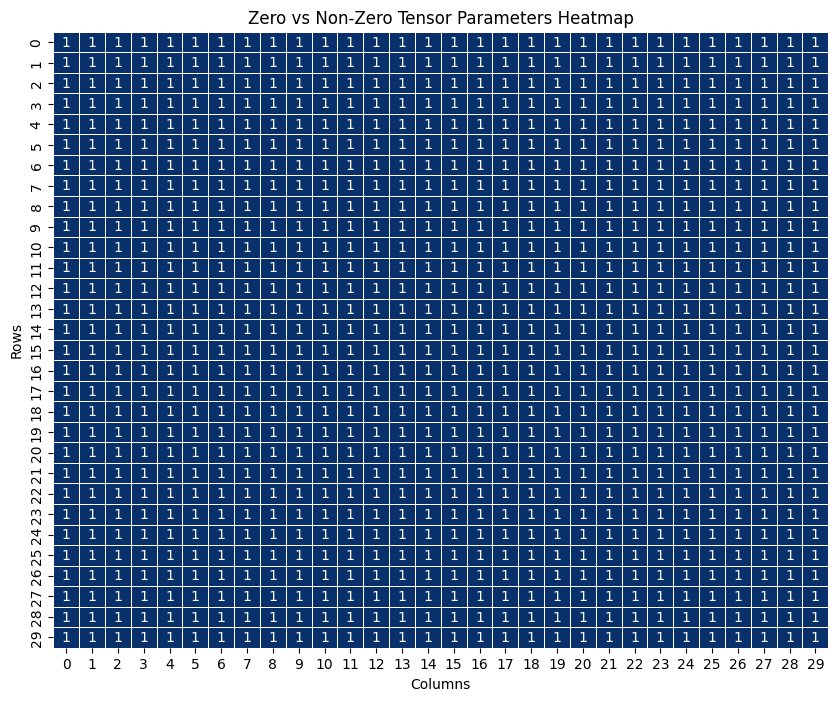

In [ ]:
#visualization for tensors
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load tensor parameters from the file
def load_tensor_data(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        data = [float(line.strip()) for line in lines]
    return np.array(data)

# Step 2: Reshape data into a 2D array
def reshape_tensor(data, rows, cols):
    if len(data) != rows * cols:
        raise ValueError("Data size does not match specified dimensions")
    return data.reshape((rows, cols))

# Step 3: Create binary heatmap data (1 for Non-Zero, 0 for Zero)
def create_binary_matrix(tensor):
    return (tensor != 0).astype(int)

# Step 4: Plot the heatmap
def plot_heatmap(binary_matrix, output_file="heatmap.png"):
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        binary_matrix,
        cmap="Blues",            # Blue for 1, White for 0
        cbar=False,                # Hide color bar for binary visualization
        linewidths=0.5,            # Add grid lines for better clarity
        annot=True,                # Annotate cells with binary values
        fmt="d",                    # Integer format for annotations
        vmin=0,               # Explicitly set the min value for the colormap
        vmax=1                # Explicitly set the max value for the colormap
    )
    plt.title("Zero vs Non-Zero Tensor Parameters Heatmap")
    plt.xlabel("Columns")
    plt.ylabel("Rows")
    plt.savefig(output_file)
    plt.show()

# Main function
if __name__ == "__main__":
    # Input file and tensor dimensions
    file_path = "./sparsed_parameters/blk.0.attn_output.weight.txt"  # Path to the file with tensor parameters
    rows, cols = 30, 30           # Adjust based on the tensor shape

    # Load, reshape, and process the tensor data
    tensor_data = load_tensor_data(file_path)
    tensor_matrix = reshape_tensor(tensor_data, rows, cols)
    binary_matrix = create_binary_matrix(tensor_matrix)

    # Plot the heatmap
    plot_heatmap(binary_matrix)


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import os

# Step 1: Load the Hugging Face model
model_name = "(your location)/Llama-2-7b-hf-sparsified"  # Replace with your model path
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Step 2: Remove all zeros from tensors and reshape correctly
def remove_zeros_and_preserve_shape(tensor):
    """Remove zeros and reshape tensor to a valid shape."""
    flattened_tensor = tensor[tensor != 0]  # Remove zeros
    new_size = flattened_tensor.size(0)
    # Maintain original shape where possible, fallback to 1D
    reshaped_tensor = flattened_tensor.view(-1)  # Reshape to 1D
    return reshaped_tensor

def update_model_tensors(model):
    """Update all tensors in the model by removing zeros."""
    with torch.no_grad():
        for name, param in model.named_parameters():
            if param.is_floating_point():  # Focus on floating-point tensors
                if (param == 0).any():  # Check if tensor contains zeros
                    print(f"Processing tensor: {name}")
                    param.data = remove_zeros_and_preserve_shape(param.data)
    return model

# Apply tensor updates
model = update_model_tensors(model)
for name, param in model.named_parameters():
    print(f"Tensor {name}: shape {param.shape}")
# Step 3: Save the modified model
output_dir = "(your location)/Llama-2-7b-updated"
os.makedirs(output_dir, exist_ok=True)
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"Updated model saved to {output_dir}")


# Step 4: Convert to GGML format for llama.cpp
# Example: python3 convert-to-ggml.py --model-dir /home/ycyite/Project/Llama-2-7b-updated --output llama2-ggml


Loading checkpoint shards: 100%|██████████| 3/3 [00:02<00:00,  1.19it/s]


Processing tensor: model.embed_tokens.weight
Processing tensor: model.layers.0.self_attn.q_proj.weight
Processing tensor: model.layers.0.self_attn.k_proj.weight
Processing tensor: model.layers.0.self_attn.v_proj.weight
Processing tensor: model.layers.0.self_attn.o_proj.weight
Processing tensor: model.layers.0.mlp.gate_proj.weight
Processing tensor: model.layers.0.mlp.up_proj.weight
Processing tensor: model.layers.0.mlp.down_proj.weight
Processing tensor: model.layers.1.self_attn.q_proj.weight
Processing tensor: model.layers.1.self_attn.k_proj.weight
Processing tensor: model.layers.1.self_attn.v_proj.weight
Processing tensor: model.layers.1.self_attn.o_proj.weight
Processing tensor: model.layers.1.mlp.gate_proj.weight
Processing tensor: model.layers.1.mlp.up_proj.weight
Processing tensor: model.layers.1.mlp.down_proj.weight
Processing tensor: model.layers.2.self_attn.q_proj.weight
Processing tensor: model.layers.2.self_attn.k_proj.weight
Processing tensor: model.layers.2.self_attn.v_pro

In [ ]:
#Checking the data type for parameters in llama2 7b hugging face model
from transformers import AutoModelForCausalLM

model_name = "(your location)/Llama-2-7b-hf" 
model = AutoModelForCausalLM.from_pretrained(model_name)
for name, param in model.named_parameters():
    print(f"Parameter: {name}, Data Type: {param.dtype}")
    


Loading checkpoint shards: 100%|██████████| 2/2 [00:09<00:00,  4.63s/it]


Parameter: model.embed_tokens.weight, Data Type: torch.float32
Parameter: model.layers.0.self_attn.q_proj.weight, Data Type: torch.float32
Parameter: model.layers.0.self_attn.k_proj.weight, Data Type: torch.float32
Parameter: model.layers.0.self_attn.v_proj.weight, Data Type: torch.float32
Parameter: model.layers.0.self_attn.o_proj.weight, Data Type: torch.float32
Parameter: model.layers.0.mlp.gate_proj.weight, Data Type: torch.float32
Parameter: model.layers.0.mlp.up_proj.weight, Data Type: torch.float32
Parameter: model.layers.0.mlp.down_proj.weight, Data Type: torch.float32
Parameter: model.layers.0.input_layernorm.weight, Data Type: torch.float32
Parameter: model.layers.0.post_attention_layernorm.weight, Data Type: torch.float32
Parameter: model.layers.1.self_attn.q_proj.weight, Data Type: torch.float32
Parameter: model.layers.1.self_attn.k_proj.weight, Data Type: torch.float32
Parameter: model.layers.1.self_attn.v_proj.weight, Data Type: torch.float32
Parameter: model.layers.1.sel

  Sparsity type        Method  PPL_Test
0           2:4     magnitude   54.3866
1           4:8     magnitude   16.5274
2  unstructured     magnitude   14.8965
3           2:4     sparsegpt    8.2769
4           4:8     sparsegpt    6.8333
5  unstructured     sparsegpt    6.0949
6           2:4         wanda   10.5086
7           4:8         wanda    7.6721
8  unstructured         wanda    6.3050
9          none  unsparsified    5.1165


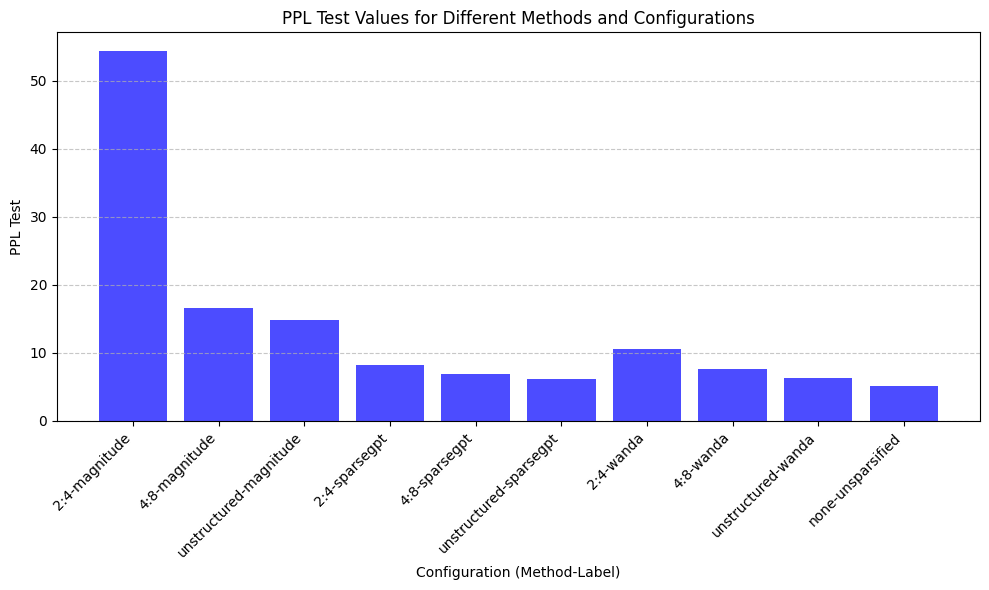

In [ ]:
#Visulization for the result of sparsification
import os
import pandas as pd
import matplotlib.pyplot as plt
# Define the file paths
file_paths = [
    "(your location)/llama_7b/2:4/magnitude/log_magnitude.txt",
    "(your location)/llama_7b/4:8/magnitude/log_magnitude.txt",
    "(your location)/llama_7b/unstructured/magnitude/log_magnitude.txt",
    "(your location)/llama_7b/2:4/sparsegpt/log_sparsegpt.txt",
    "(your location)/llama_7b/4:8/sparsegpt/log_sparsegpt.txt",
    "(your location)/llama_7b/unstructured/sparsegpt/log_sparsegpt.txt",
    "(your location)/llama_7b/2:4/wanda/log_wanda.txt",
    "(your location)/llama_7b/4:8/wanda/log_wanda.txt",
    "(your location)/llama_7b/unstructured/wanda/log_wanda.txt",
    "(your location)/llama_7b/none/unsparsified/log_wanda.txt"
]

# Initialize an empty list to store the data
data = []

# Extract data from each file
# Initialize an empty list to store the data again
data = []

# Extract data from each file based on the updated information
for file_path in file_paths:
    # Extract labels from the file path
    parts = file_path.split('/')
    label1, label2 = parts[-3], parts[-2]

    # Read the file and extract the 'ppl_test' value
    if os.path.exists(file_path):
        with open(file_path, 'r') as file:
            lines = file.readlines()
            if len(lines) >= 2:  # Ensure the second row exists
                second_row = lines[1].strip().split()
                if len(second_row) >= 3:  # Ensure the third column exists
                    ppl_test = float(second_row[2])
                    data.append({"Sparsity type": label1, "Method": label2, "PPL_Test": ppl_test})

# Convert the data into a DataFrame
df = pd.DataFrame(data)
print(df)
# Plot the data if it exists
# Plot the data as a bar chart if it exists
if not df.empty:
    # Create a new column combining Label1 and Label2 for easier visualization
    df["Combined_Label"] = df["Sparsity type"] + "-" + df["Method"]

    # Plotting a bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(df["Combined_Label"], df["PPL_Test"], color='blue', alpha=0.7)
    plt.title("PPL Test Values for Different Methods and Configurations")
    plt.xlabel("Configuration (Method-Label)")
    plt.ylabel("PPL Test")
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("No data available to plot.")


# Display the data to the user

